# Deflection of Sheet While Sealing Material

For M3 and M4 bolts for the lid and back panel

**Flexural Modulus**:
* https://www.mcmaster.com/8574K26/
* For Polycarb: 350,000 psi
* A substitute for elastic modulus for some materials

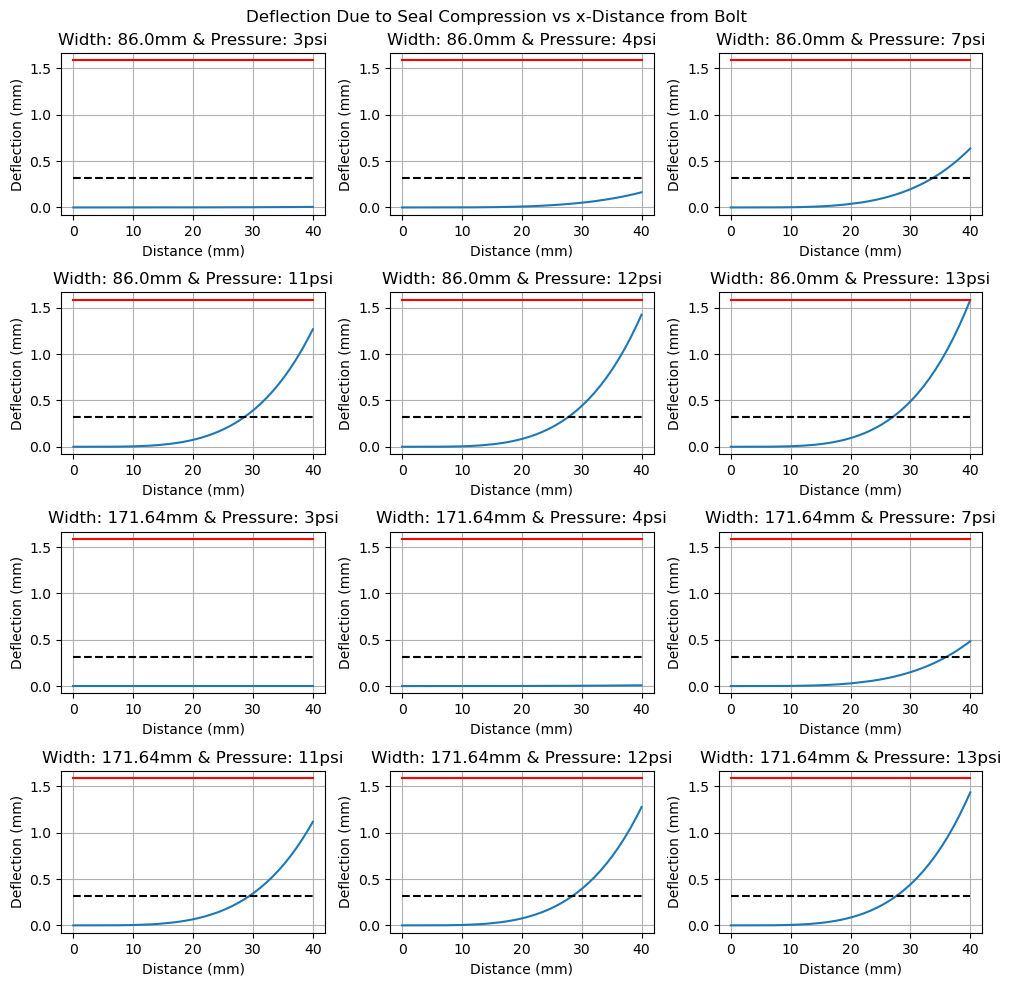

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt

### DEFINE CONSTANTS

# Seal Parameters
pressure_psi = np.array([3, 4, 7, 11, 12, 13])          # psi - pressures required to compress seal by 25%
pressure_mpa = pressure_psi / 145.038                   # N/mm2 - conversion from imperial to metric
seal_thickness = 1/16 * 25.4                            # mm - seal thickness (assumed 1/16")
comp_25 = 0.25 * seal_thickness                         # mm - distance to compress seal by 25%
seal_slope = pressure_mpa / comp_25                     # N/mm3 - slope of line to approximate pressure compared to distance compressed
seal_total_A = [5473.94, 11034.04]                      # mm2 - seal area for lid and back panel, respectively

# For M3 and M4
bolt_diameter = np.array([3, 4])                        # mm - options for bolt diameters
bolt_area = math.pi * bolt_diameter**2 / 4              # mm2 - bolt areas
washer_diameter = np.array([7, 9])                      # mm - for M3 and M4 washers, respectively
washer_area = math.pi * washer_diameter**2 / 4          # mm2 - washer areas
tensile_stress_area = np.array([5.08, 8.78])            # mm2 - for M3 and M4 bolts, respectively
bolt_S_ut = 110 * 10**3 / 145.038                       # N/mm2 - tensile strength of bolt
n_d = 1 / 0.10                                          # design factor for bolt pre-tension
bolt_Fi = bolt_S_ut * tensile_stress_area / n_d         # N - bolt pretension (estimates!!)

# Plate geometry and properties
lid_thickness = 3.18                                    # mm - sheet thickness
lid_width = np.array([86, 171.64])                      # mm - widths from one side of bolts to other
PC_flexural_modulus = 350 * 10^5                        # psi - flexural modulus of PC
lid_flex = PC_flexural_modulus / 145.038                # N/mm2
lid_E = 1.67 * 10**3                                    # N/mm2
PC_S_ut = 8900                                          # psi - tensile strength of PC
lid_S_ut = PC_S_ut / 145.038                            # N/mm2
lid_SMOA = 1/12 * lid_width * lid_thickness**3          # mm^4 - second moments of area of lid
PC_density = 1190.236                                   # kg/m3 - https://www.mcmaster.com/8574K26/
g = 9.81                                                # N/kg

# Subplot parameters
rows = 4
cols = 3
FIGWIDTH = 10
FIGHEIGHT = 10
fig, ax = plt.subplots(rows, cols, figsize=(FIGWIDTH, FIGHEIGHT))
supTitle = "Deflection Due to Seal Compression vs x-Distance from Bolt"
fig.suptitle(supTitle)
row_counter = 0
col_counter = 0

# Other parameters
acceptable_deflection = 0.20 * seal_thickness         # mm - what is the maximum acceptable deflection

### CHOOSE PARAMETERS (basically just choose 0 or 1)
for k in range(0, 2):   # for all k options
    for j in range(0, len(pressure_psi)):

        # Chosen diameters
        washer_d = washer_diameter[k]
        washer_A = washer_area[k]
        bolt_d = bolt_diameter[k]
        bolt_A = bolt_area[k]

        # Choose seal geometry
        seal_A = seal_total_A[k]
        P_MPa = pressure_mpa[j]         # !!! change later to do all calculations at once
        seal_m = seal_slope[k]

        # Chosen plate geometry
        lid_w = lid_width[k]
        lid_I = lid_SMOA[k]

        # distributed load due to mass of plate
        w_0 = PC_density * g * lid_w * seal_thickness / 1000**3 # N/mm

        ### CALCULATIONS
        num = 600                                                # number of elements (essentially mesh size)
        max_dist = 40                                            # mm - max distance for simulation
        x = np.linspace(0, max_dist, num)                        # mm - representing distance along a 2D surface
        dx = x[1] - x[0]                                         # mm - delta x value

        # calculate force exerted by compressive material and resulting deflection
        Force = np.array([P_MPa * dx * lid_w])
        Pressure = np.array([P_MPa])
        Deflection = np.array([0])
        x_values = np.array([0])

        for i in range(0, num-1):
            # 1) Calculate new force
            newForce = Pressure[i] * dx * lid_w                 # N - Force on small section of plate
            Force = np.append(Force, newForce)                  # N - add to force vector

            # 2) Determine next deflection
            x_values = np.insert(x_values, 0, x[i])
            y = 1 / (6 * lid_E * lid_I) * (Force * x_values**3)
            y_ = np.sum(y)
            y_PC_mass = -1 / (lid_E * lid_I * 24) * w_0 * x[i]**4                       # mm - deflection from distributed mass of plate
            y_sum = y_ + y_PC_mass                                                      # mm - total deflection from PC mass and others
            if y_sum < 0:
                y_sum = 0
            Deflection = np.append(Deflection, y_sum)                                   # mm - add to deflection vector
            
            # 3) New pressure based on deflection
            if y_sum > seal_thickness:
                newPressure = 0
            else:
                newPressure = P_MPa + seal_m * (Deflection[i] - comp_25)                        # N/mm2 - next pressure
            Pressure = np.append(Pressure, newPressure)
        
        # Plot result in desired subplot
        this_ax = ax[row_counter][col_counter]
        this_ax.plot(x, Deflection, label="Deflection")
        title = "Width: " + str(lid_w) + "mm & Pressure: " + str(pressure_psi[j]) + "psi"
        this_ax.set_title(title)
        this_ax.set_xlabel("Distance (mm)")
        this_ax.set_ylabel("Deflection (mm)")
        this_ax.plot(x, np.ones(num) * seal_thickness, 'r', label="Seal Thickness")
        this_ax.plot(x, np.ones(num) * acceptable_deflection, 'k--', label="Max Allowed Deflection")
        this_ax.grid(True)
        #this_ax.legend()

        if col_counter == 2:
            col_counter = 0
            row_counter = row_counter + 1
        else:
            col_counter = col_counter + 1

plt.tight_layout(pad=1)

### Calculations for Jenibelle's Fan Module

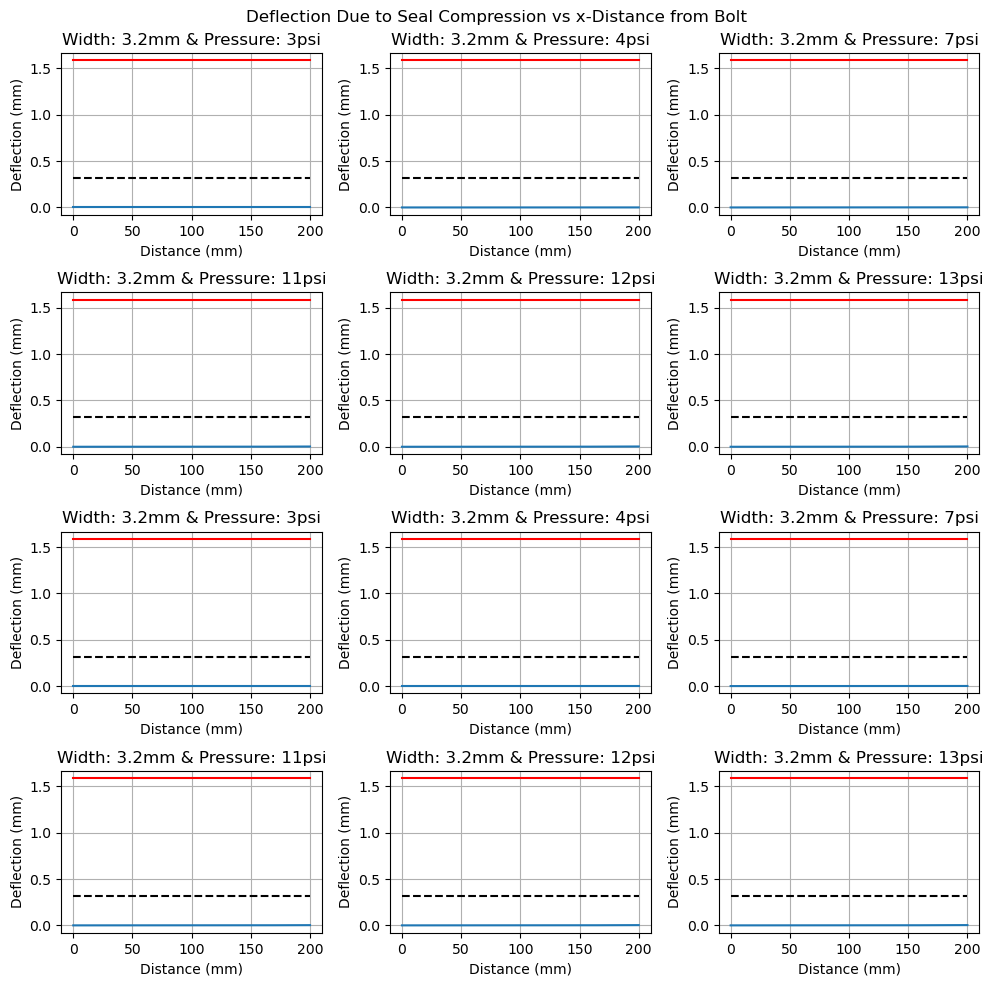

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt

### DEFINE CONSTANTS

# Seal Parameters
pressure_psi = np.array([3, 4, 7, 11, 12, 13])          # psi - pressures required to compress seal by 25%
pressure_mpa = pressure_psi / 145.038                   # N/mm2 - conversion from imperial to metric
seal_thickness = 1/16 * 25.4                            # mm - seal thickness (assumed 1/16")
comp_25 = 0.25 * seal_thickness                         # mm - distance to compress seal by 25%
seal_slope = pressure_mpa / comp_25                     # N/mm3 - slope of line to approximate pressure compared to distance compressed
# seal_total_A = [5473.94, 11034.04]                      # mm2 - seal area for lid and back panel, respectively

# For M3 and M4
bolt_diameter = np.array([3, 4])                        # mm - options for bolt diameters
bolt_area = math.pi * bolt_diameter**2 / 4              # mm2 - bolt areas
washer_diameter = np.array([7, 9])                      # mm - for M3 and M4 washers, respectively
washer_area = math.pi * washer_diameter**2 / 4          # mm2 - washer areas
tensile_stress_area = np.array([5.08, 8.78])            # mm2 - for M3 and M4 bolts, respectively
bolt_S_ut = 110 * 10**3 / 145.038                       # N/mm2 - tensile strength of bolt (80-200 psi)
n_d = 1 / 0.10                                          # design factor for bolt pre-tension
bolt_Fi = bolt_S_ut * tensile_stress_area / n_d         # N - bolt pretension (estimates!!)

# Plate geometry and properties
lid_thickness = 0.06 * 25.4                             # mm - sheet metal bracket height (however, this component is actually the carbon fibre)
lid_thickness = 61.68                                   # mm - sheet metal bracket height (however, this component is actually the carbon fibre)
lid_width = np.array([3.2, 3.2])                        # mm - widths from one side of bolts to other
lid_E = 70.3 * 10**3                                    # N/mm2 - for Al 5052
lid_S_ut = 228                                          # N/mm2 - for Al 5052
lid_SMOA = 1/12 * lid_width * lid_thickness**3          # mm^4 - second moments of area of lid
PC_density = 2680                                       # kg/m3 - https://www.mcmaster.com/8574K26/
g = 9.81                                                # N/kg

# Subplot parameters
rows = 4
cols = 3
FIGWIDTH = 10
FIGHEIGHT = 10
fig, ax = plt.subplots(rows, cols, figsize=(FIGWIDTH, FIGHEIGHT))
supTitle = "Deflection Due to Seal Compression vs x-Distance from Bolt"
fig.suptitle(supTitle)
row_counter = 0
col_counter = 0

# Other parameters
acceptable_deflection = 0.20 * seal_thickness         # mm - what is the maximum acceptable deflection

### CHOOSE PARAMETERS (basically just choose 0 or 1)
for k in range(0, 2):   # for all k options
    for j in range(0, len(pressure_psi)):

        # Chosen diameters
        washer_d = washer_diameter[k]
        washer_A = washer_area[k]
        bolt_d = bolt_diameter[k]
        bolt_A = bolt_area[k]

        # Choose seal geometry
        # seal_A = seal_total_A[k]
        P_MPa = pressure_mpa[j]         # !!! change later to do all calculations at once
        seal_m = seal_slope[k]

        # Chosen plate geometry
        lid_w = lid_width[k]
        lid_I = lid_SMOA[k]

        # distributed load due to mass of plate
        w_0 = PC_density * g * lid_w * seal_thickness / 1000**3 # N/mm

        ### CALCULATIONS
        num = 600                                                # number of elements (essentially mesh size)
        max_dist = 200                                            # mm - max distance for simulation
        x = np.linspace(0, max_dist, num)                        # mm - representing distance along a 2D surface
        dx = x[1] - x[0]                                         # mm - delta x value

        # calculate force exerted by compressive material and resulting deflection
        Force = np.array([P_MPa * dx * lid_w])
        Pressure = np.array([P_MPa])
        Deflection = np.array([0])
        x_values = np.array([0])

        for i in range(0, num-1):
            # 1) Calculate new force
            newForce = Pressure[i] * dx * lid_w                 # N - Force on small section of plate
            Force = np.append(Force, newForce)                  # N - add to force vector

            # 2) Determine next deflection
            x_values = np.insert(x_values, 0, x[i])
            y = 1 / (6 * lid_E * lid_I) * (Force * x_values**3)
            y_ = np.sum(y)
            y_PC_mass = -1 / (lid_E * lid_I * 24) * w_0 * x[i]**4                       # mm - deflection from distributed mass of plate
            y_sum = y_ + y_PC_mass                                                      # mm - total deflection from PC mass and others
            if y_sum < 0:
                y_sum = 0
            Deflection = np.append(Deflection, y_sum)                                   # mm - add to deflection vector
            
            # 3) New pressure based on deflection
            if y_sum > seal_thickness:
                newPressure = 0
            else:
                newPressure = P_MPa + seal_m * (Deflection[i] - comp_25)                        # N/mm2 - next pressure
            Pressure = np.append(Pressure, newPressure)
        
        # Plot result in desired subplot
        this_ax = ax[row_counter][col_counter]
        this_ax.plot(x, Deflection, label="Deflection")
        title = "Width: " + str(lid_w) + "mm & Pressure: " + str(pressure_psi[j]) + "psi"
        this_ax.set_title(title)
        this_ax.set_xlabel("Distance (mm)")
        this_ax.set_ylabel("Deflection (mm)")
        this_ax.plot(x, np.ones(num) * seal_thickness, 'r', label="Seal Thickness")
        this_ax.plot(x, np.ones(num) * acceptable_deflection, 'k--', label="Max Allowed Deflection")
        this_ax.grid(True)
        #this_ax.legend()

        if col_counter == 2:
            col_counter = 0
            row_counter = row_counter + 1
        else:
            col_counter = col_counter + 1

plt.tight_layout(pad=1)

### Levi's Enclosure Lid

Height of seal above enclosure could be decreased to 1.15 mm

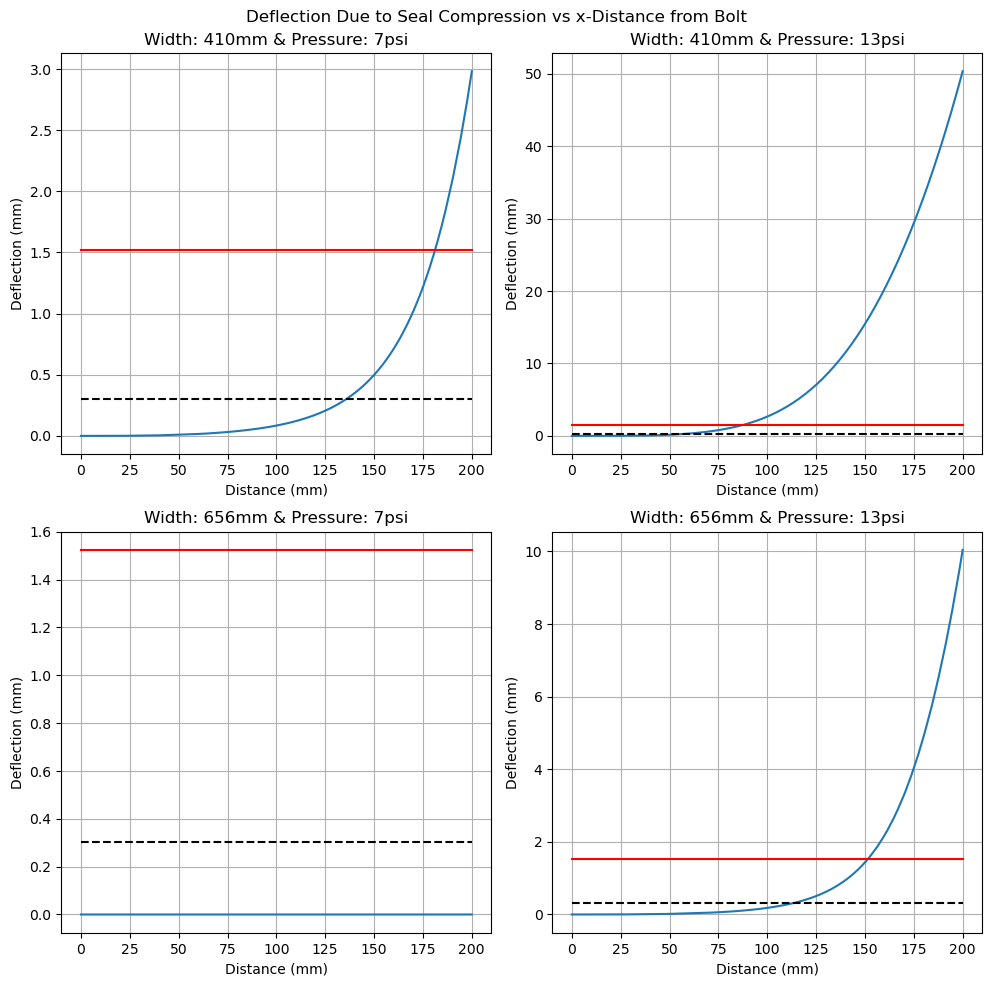

In [6]:
seal_thickness = 0.03                   # in
t = seal_thickness * 2                  # in - total seal thickness
t_comp_25 = 0.75 * t * 25.4                   # in - compressed thickness

import numpy as np
import math
import matplotlib.pyplot as plt

### DEFINE CONSTANTS

# Seal Parameters
pressure_psi = np.array([7, 13])                        #  psi - pressures required to compress seal by 25%: https://www.mcmaster.com/products/seals/foam~/ultra-weather-resistant-epdm-foam-sheets-and-strips/ 
pressure_mpa = pressure_psi / 145.038                   # N/mm2 - conversion from imperial to metric
seal_thickness = 0.03 * 2 * 25.4                        # mm - seal thickness (assumed 1/16")
comp_25 = 0.25 * seal_thickness                         # mm - distance to compress seal by 25%
seal_slope = pressure_mpa / comp_25                     # N/mm3 - slope of line to approximate pressure compared to distance compressed
# seal_total_A = [5473.94, 11034.04]                    # mm2 - seal area for lid and back panel, respectively

# For M3 and M4
bolt_diameter = np.array([3, 4])                        # mm - options for bolt diameters
bolt_area = math.pi * bolt_diameter**2 / 4              # mm2 - bolt areas
washer_diameter = np.array([7, 9])                      # mm - for M3 and M4 washers, respectively
washer_area = math.pi * washer_diameter**2 / 4          # mm2 - washer areas
tensile_stress_area = np.array([5.08, 8.78])            # mm2 - for M3 and M4 bolts, respectively
bolt_S_ut = 110 * 10**3 / 145.038                       # N/mm2 - tensile strength of bolt (80-200 psi)
n_d = 1 / 0.10                                          # design factor for bolt pre-tension
bolt_Fi = bolt_S_ut * tensile_stress_area / n_d         # N - bolt pretension (estimates!!)

# Plate geometry and properties
lid_thickness = 2.3                                     # mm - sheet metal bracket height (however, this component is actually the carbon fibre)
lid_width = np.array([410, 656])                        # mm - widths from one side of bolts to other
lid_E = 70.3 * 10**3                                    # N/mm2 - for Al 5052
lid_S_ut = 228                                          # N/mm2 - for Al 5052
lid_SMOA = 1/12 * lid_width * lid_thickness**3          # mm^4 - second moments of area of lid
PC_density = 2680                                       # kg/m3 - https://www.mcmaster.com/8574K26/
g = 9.81                                                # N/kg

# Subplot parameters
rows = 2
cols = 2
FIGWIDTH = 10
FIGHEIGHT = 10
fig, ax = plt.subplots(rows, cols, figsize=(FIGWIDTH, FIGHEIGHT))
supTitle = "Deflection Due to Seal Compression vs x-Distance from Bolt"
fig.suptitle(supTitle)
row_counter = 0
col_counter = 0

# Other parameters
acceptable_deflection = 0.20 * seal_thickness         # mm - what is the maximum acceptable deflection

### CHOOSE PARAMETERS (basically just choose 0 or 1)
for k in range(0, 2):   # for all k options
    for j in range(0, len(pressure_psi)):

        # Chosen diameters
        washer_d = washer_diameter[k]
        washer_A = washer_area[k]
        bolt_d = bolt_diameter[k]
        bolt_A = bolt_area[k]

        # Choose seal geometry
        # seal_A = seal_total_A[k]
        P_MPa = pressure_mpa[j]         # !!! change later to do all calculations at once
        seal_m = seal_slope[k]

        # Chosen plate geometry
        lid_w = lid_width[k]
        lid_I = lid_SMOA[k]

        # distributed load due to mass of plate
        w_0 = PC_density * g * lid_w * seal_thickness / 1000**3 # N/mm

        ### CALCULATIONS
        num = 600                                                # number of elements (essentially mesh size)
        max_dist = 200                                            # mm - max distance for simulation
        x = np.linspace(0, max_dist, num)                        # mm - representing distance along a 2D surface
        dx = x[1] - x[0]                                         # mm - delta x value

        # calculate force exerted by compressive material and resulting deflection
        Force = np.array([P_MPa * dx * lid_w])
        Pressure = np.array([P_MPa])
        Deflection = np.array([0])
        x_values = np.array([0])

        for i in range(0, num-1):
            # 1) Calculate new force
            newForce = Pressure[i] * dx * lid_w                 # N - Force on small section of plate
            Force = np.append(Force, newForce)                  # N - add to force vector

            # 2) Determine next deflection
            x_values = np.insert(x_values, 0, x[i])
            y = 1 / (6 * lid_E * lid_I) * (Force * x_values**3)
            y_ = np.sum(y)
            y_PC_mass = -1 / (lid_E * lid_I * 24) * w_0 * x[i]**4                       # mm - deflection from distributed mass of plate
            y_sum = y_ + y_PC_mass                                                      # mm - total deflection from PC mass and others
            if y_sum < 0:
                y_sum = 0
            Deflection = np.append(Deflection, y_sum)                                   # mm - add to deflection vector
            
            # 3) New pressure based on deflection
            if y_sum > seal_thickness:
                newPressure = 0
            else:
                newPressure = P_MPa + seal_m * (Deflection[i] - comp_25)                        # N/mm2 - next pressure
            Pressure = np.append(Pressure, newPressure)
        
        # Plot result in desired subplot
        this_ax = ax[row_counter][col_counter]
        this_ax.plot(x, Deflection, label="Deflection")
        title = "Width: " + str(lid_w) + "mm & Pressure: " + str(pressure_psi[j]) + "psi"
        this_ax.set_title(title)
        this_ax.set_xlabel("Distance (mm)")
        this_ax.set_ylabel("Deflection (mm)")
        this_ax.plot(x, np.ones(num) * seal_thickness, 'r', label="Seal Thickness")
        this_ax.plot(x, np.ones(num) * acceptable_deflection, 'k--', label="Max Allowed Deflection")
        this_ax.grid(True)
        #this_ax.legend()

        if col_counter == (cols - 1):
            col_counter = 0
            row_counter = row_counter + 1
        else:
            col_counter = col_counter + 1

plt.tight_layout(pad=1)